# **Team 3 - Project Delivery 2**

**Team members:**

  - Daniel Alejandro Rincón Rico
  - Juan Sebastián Alcina Rodríguez
  - Ivan Andres Lemus Moreno
  - Leidy Johana Llanos Culma
  - Mario Montero
  - José Fabián García Camargo

**System name:** Netflix

**System description:** The Netflix clone project is a streaming platform with secure user authentication, multiple profiles per account, integrated payment processing, real-time movie updates and AI based recommendations. It delivers high-quality content and constantly refreshes its library to provide the latest films and shows. The platform is built in microservices architecture, ensure scalability and maintainability.

**Source Repository:** https://github.com/almoghindi/NetflixClone

## **Common functions**

Functions commonly used across all iterations.

Using Lab 5 from the course as a reference, we implemented these functions to visualize the nodes of our architecture and to display the corresponding metrics for each execution.

Additionally, we added a function to visualize the cache simulation separately.

### Run simulation

In [ ]:
def run_stream_simulation():
    """
    Configura la arquitectura del sistema, ejecuta la simulación de transacciones,
    reporta los resultados, visualiza las métricas y representa la arquitectura antes y después
    de inducir una falla.
    """
    # Setup architecture
    components, graph = setup_architecture()

    # Represent the initial architecture
    print("=== Initial Architecture Representation ===")
    represent_graph(graph, components)

    # Metrics collection
    metrics = []

    # Simulate transactions with initial capacity
    print("\n=== Simulating Transactions with Initial Architecture ===")
    run_simulation(components, metrics)
    report_metrics(metrics)
    visualize_metrics(metrics)

    # Clear previous metrics
    metrics.clear()

    # Simulate transactions after inducing failure
    print("\n=== Simulating Transactions with Failure Scenario ===")
    run_simulation(components, metrics, True)
    report_metrics(metrics)
    visualize_metrics(metrics)

    # Represent the architecture after failure
    print("\n=== Architecture Representation After Failure ===")
    represent_graph(graph, components)


### Metrics utils

In [ ]:
# @title
def represent_graph(graph, components):
    """
    Represents the architecture as a graph.
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.5, iterations=50)

    # Assign colors based on component type
    color_map = {
        'Presentation Tier': 'lightblue',
        'Logic Tier': 'lightgreen',
        'Data Tier': 'orange',
        'CyberPhysical Tier': 'red'
    }
    node_colors = [color_map[components[node].component_type] for node in graph.nodes()]

    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=5000,
        font_size=7,
        font_weight='bold',
        arrows=True
    )
    plt.title("Netflix Architecture Represented as a Graph")
    plt.show()

def visualize_metrics(metrics):
    """
    Visualizes the collected metrics using bar charts.
    """
    total = len(metrics)
    success = sum(1 for tx in metrics if tx.status == 'Success')
    failed = sum(1 for tx in metrics if tx.status == 'Failed')
    blocked = sum(1 for tx in metrics if tx.status == 'Blocked')

    labels = ['Successful', 'Failed', 'Blocked']
    counts = [success, failed, blocked]
    colors = ['green', 'red', 'gray']

    plt.figure(figsize=(6, 6))
    plt.bar(labels, counts, color=colors)
    plt.title('Successful vs Failed Transactions')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.show()

    type_metrics = defaultdict(lambda: {'Success': 0, 'Failed': 0, 'Blocked': 0})
    for tx in metrics:
        type_metrics[tx.transaction_type][tx.status] += 1

    types = list(type_metrics.keys())
    success_counts = [type_metrics[t]['Success'] for t in types]
    failed_counts = [type_metrics[t]['Failed'] for t in types]
    blocked_counts = [type_metrics[t]['Blocked'] for t in types]

    x = range(len(types))

    plt.figure(figsize=(12, 8))
    plt.bar(x, success_counts, width=0.4, label='Successful', color='green')
    plt.bar([p + 0.4 for p in x], failed_counts, width=0.4, label='Failed', color='red')
    plt.bar([p + 0.8 for p in x], blocked_counts, width=0.4, label='Blocked', color='gray')
    plt.xlabel('Transaction Type')
    plt.ylabel('Count')
    plt.title('Transactions by Type')
    plt.xticks([p + 0.2 for p in x], [t.name.capitalize() for t in types], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def report_metrics(metrics):
    """
    Displays the metrics collected during the simulation.
    """
    total = len(metrics)
    success = sum(1 for tx in metrics if tx.status == 'Success')
    failed = sum(1 for tx in metrics if tx.status == 'Failed')
    blocked = sum(1 for tx in metrics if tx.status == 'Blocked')
    print(f"\n=== Simulation Results ===")
    print(f"Total Transactions: {total}")
    print(f"Successful Transactions: {success}")
    print(f"Failed Transactions: {failed}\n")
    print(f"Blocked Transactions: {blocked}\n")

    type_metrics = defaultdict(lambda: {'Success': 0, 'Failed': 0, 'Blocked': 0})
    for tx in metrics:
        type_metrics[tx.transaction_type][tx.status] += 1

    print("Summary by Transaction Type:")
    for t_type, counts in type_metrics.items():
        print(f"  {TransactionType(t_type).name.capitalize()}: {counts['Success']} successful, {counts['Failed']} failed, {counts['Blocked']} blocked")

    component_metrics = defaultdict(lambda: {'Processed': 0, 'Failed': 0, 'Blocked': 0})
    for tx in metrics:
        for comp in tx.components_involved:
            component_metrics[comp]['Processed'] += 1
        if tx.status == 'Failed':
            for comp in tx.components_involved:
                component_metrics[comp]['Failed'] += 1
        if tx.status == 'Blocked':
            for comp in tx.components_involved:
                component_metrics[comp]['Blocked'] += 1

    print("\nSummary by Component:")
    for comp, counts in component_metrics.items():
        print(f"  {comp}: Processed {counts['Processed']}, Failed {counts['Failed']}, Blocked {counts['Blocked']}")

    print("\nDetails of Failed Transactions:")
    for tx in metrics:
       # if tx.status == '88d': # <--------------------------------------------------------------------------------------------------------------------------- logger
            if tx.transaction_type == 'purchase':
                user = tx.user
            else:
                user = f"{tx.user} in {tx.transaction_type}"
            #print(f"User: {user}, Type: {tx.transaction_type}, Components: {tx.components_involved}, Status: {tx.status}")

def visualize_cache_usage(metrics):

    print("\n=== Métricas de Caché ===\n")
    """
    Genera un gráfico separado mostrando el uso de la caché vs el streamer.
    """
    cache_access_count = len([
        tx for tx in metrics
        if tx.transaction_type == TransactionType.STREAM
    ])

    cache_hits = sum(
        1 for tx in metrics
        if tx.transaction_type == TransactionType.STREAM and tx.status == "Success"
        and tx.components_involved == ["stream_user_ms", "stream_cache"]
    )

    db_hits = sum(
        1 for tx in metrics
        if tx.transaction_type == TransactionType.STREAM and tx.status == "Success"
        and "stream_streamer_db" in tx.components_involved
    )

    labels = ["Accesos a caché", "Hits (desde caché)", "Hits (desde db)"]
    values = [cache_access_count, cache_hits, db_hits]

    print(f"Total de accesos a la caché: {cache_access_count}")
    print(f"Total de hits desde la caché: {cache_hits}")
    print(f"Total de hits desde la base de datos: {db_hits}\n")

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=["gray", "orange", "green"])
    plt.title("Uso de la Caché en Streaming")
    plt.ylabel("Cantidad de Transacciones")
    plt.grid(axis="y")
    plt.show()

## **Iteration 1**


In this iteration, we configured the current architecture of our project. We initialized each one of the layers, the components, and defined the connections between them.

- Initial components:

  1. stream_user_wf
  2. stream_auth_ms
  3. stream_streamer_ms
  4. stream_auth_db
  5. stream_streamer_db

Additionally, we set up the simulation to be executed in Iteration 1.

- Architectural diagram (Iteration 1)
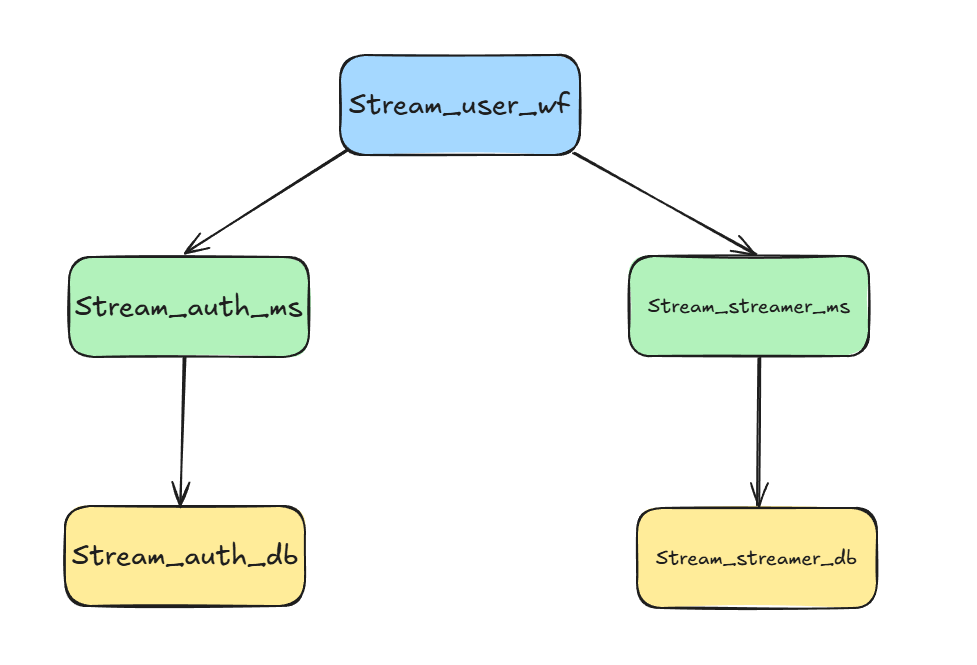

#### Modelado

In [ ]:
import threading
import time
import random
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

# ================================
# 1. Modeling
# ================================

class Component:
    """
    Base class for all architecture components.
    """
    def __init__(self, name, component_type, capacity=100):
        self.name = name
        self.component_type = component_type
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process_transaction(self, transaction):
        """
        Processes a transaction. Returns True if the transaction is processed successfully,
        or False if the component's capacity is exceeded.
        """
        with self.lock:
            if self.current_load >= self.capacity:
                return 'Failure'  # Over capacity failure
            self.current_load += 1
        # Simulate processing time
        processing_time = random.uniform(0.01, 0.05)
        time.sleep(processing_time)
        with self.lock:
            self.current_load -= 1
        return 'Success'

class PresentationTier(Component):
    """
    Class for components in Presentation Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Presentation Tier", capacity)

class LogicTier(Component):
    """
    Class for components in Logic Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Logic Tier", capacity)

class DataTier(Component):
    """
    Class for components in Data Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Data Tier", capacity)

class CyberPhysicalTier(Component):
    """
    Class for components in CyberPhysical Tier
    """
    def __init__(self, name, capacity=1000):
        super().__init__(name, "CyberPhysical Tier", capacity)

class TransactionType(Enum):
    AUTH = 1
    STREAM = 2

class Transaction:
    """
    Represents a transaction in the system.
    """
    def __init__(self, user, request_ip, transaction_type):
        self.user = user  # User identifier (e.g., "user_ma_1")
        self.request_ip = request_ip
        self.transaction_type = transaction_type
        self.components_involved = []
        self.status = None  # "Success", "Failed" or "Blocked"

In [ ]:
def setup_architecture():
    """
    Sets up the system architecture by instantiating components and defining their connections.
    """
    components = {}
    graph = nx.DiGraph()

    # Presentation Tier
    components['stream_user_wf'] = PresentationTier('ertms_user_ma', capacity=200)

    # Logic Tier
    components['stream_auth_ms'] = LogicTier('stream_auth_ms', capacity=300)
    components['stream_streamer_ms'] = LogicTier('stream_streamer_ms', capacity=300)


    # Data Tier
    components['stream_auth_db'] = DataTier('stream_auth_db', capacity=300)
    components['stream_streamer_db'] = DataTier('stream_streamer_db', capacity=300)

    # Define connections between components
    graph.add_edge('stream_user_wf', 'stream_auth_ms')
    graph.add_edge('stream_user_wf', 'stream_streamer_ms')

    graph.add_edge('stream_auth_ms', 'stream_auth_db')

    graph.add_edge('stream_streamer_ms', 'stream_streamer_db')

    return components, graph

def simulate_transaction(transaction, components, metrics):
    """
    Simulates the processing of a transaction through the involved components.
    """
    if transaction.transaction_type == TransactionType.AUTH:
        components_sequence = ['stream_user_wf', 'stream_auth_ms', 'stream_auth_db']
    elif transaction.transaction_type == TransactionType.STREAM:
        components_sequence = ['stream_user_wf', 'stream_streamer_ms', 'stream_streamer_db']
    else:
        components_sequence = []

    transaction.components_involved = components_sequence
    success = True
    for comp_name in components_sequence:
        component = components.get(comp_name)
        if component:
            transaction.status = component.process_transaction(transaction)
            break
        else:
            success = False
            transaction.status = 'Failed'
            break
    metrics.append(transaction)


#### Simulacion

In [ ]:
def run_simulation(components, metrics, inject_failure=False, total_stream_requests=1000):
    """
    Runs the simulation of concurrent transactions.
    """

    threads = []

    # Tokens válidos
    valid_tokens = {
        "token123",
        "token456",
        "token789"
    }

    # IPs validas
    global ips
    ips = ["192.168.3.15", "10.0.105.22", "172.25.1.88"]

    possible_tokens = list(valid_tokens) + ["invalid_token"]
    possible_ips = ips

    if inject_failure:
      possible_ips = ["203.0.113.45"]

    for i in range(1, total_stream_requests + 1):
      user_token = random.choice(possible_tokens)
      ip = random.choice(possible_ips)

      transaction = Transaction(user_token, ip, TransactionType.STREAM)

      thread = threading.Thread(target=simulate_transaction, args=(transaction, components, metrics))
      threads.append(thread)
      thread.start()

    for thread in threads:
        thread.join()

### Ejecutar simulación

=== Initial Architecture Representation ===


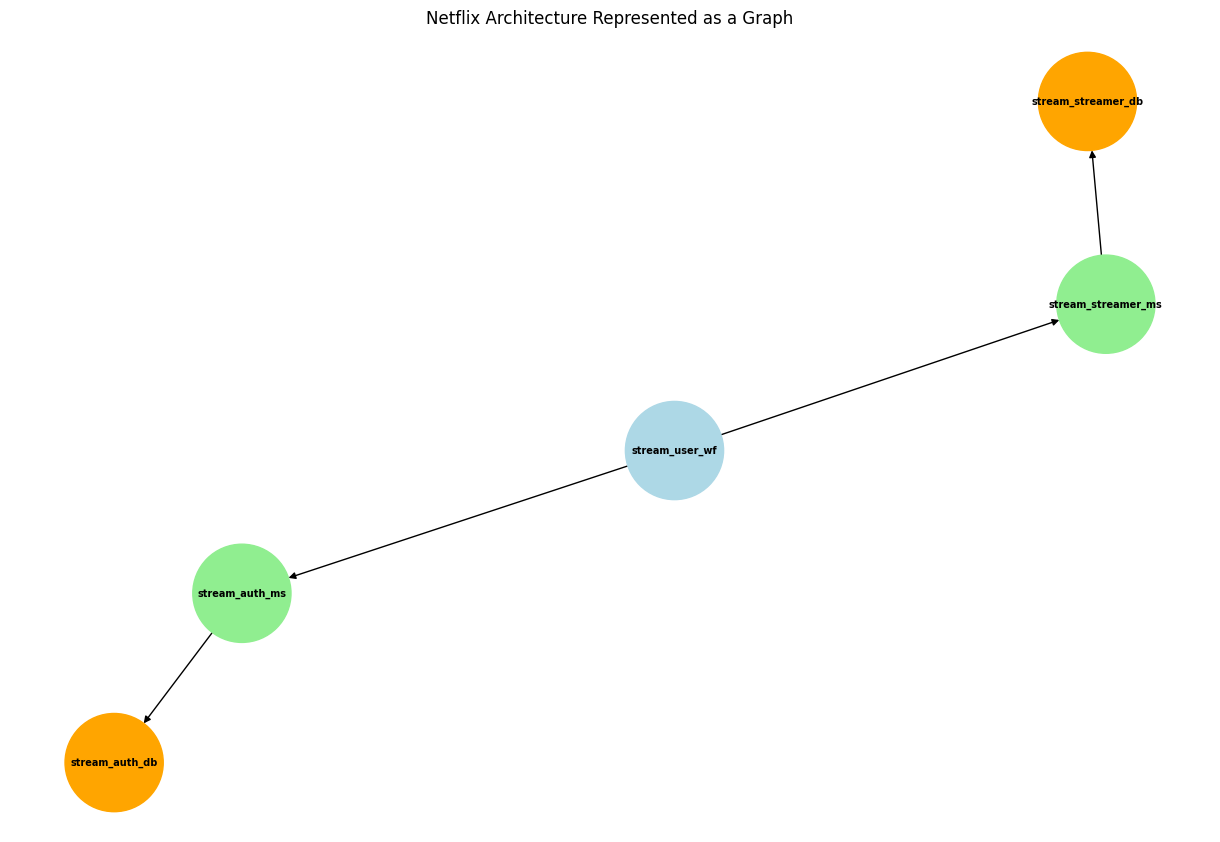


=== Simulating Transactions with Initial Architecture ===

=== Simulation Results ===
Total Transactions: 1000
Successful Transactions: 1000
Failed Transactions: 0

Blocked Transactions: 0

Summary by Transaction Type:
  Stream: 1000 successful, 0 failed, 0 blocked

Summary by Component:
  stream_user_wf: Processed 1000, Failed 0, Blocked 0
  stream_streamer_ms: Processed 1000, Failed 0, Blocked 0
  stream_streamer_db: Processed 1000, Failed 0, Blocked 0

Details of Failed Transactions:


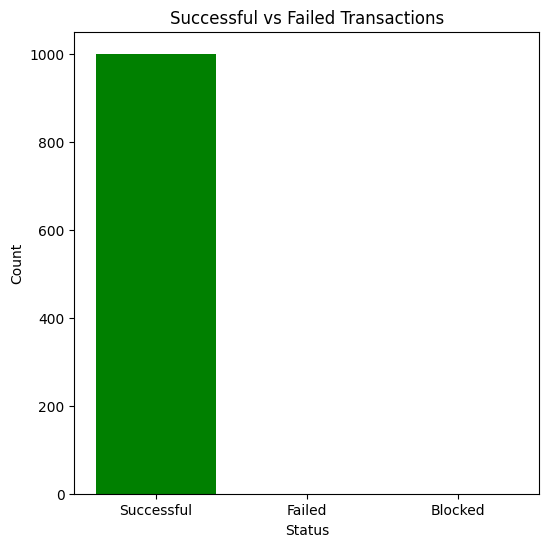

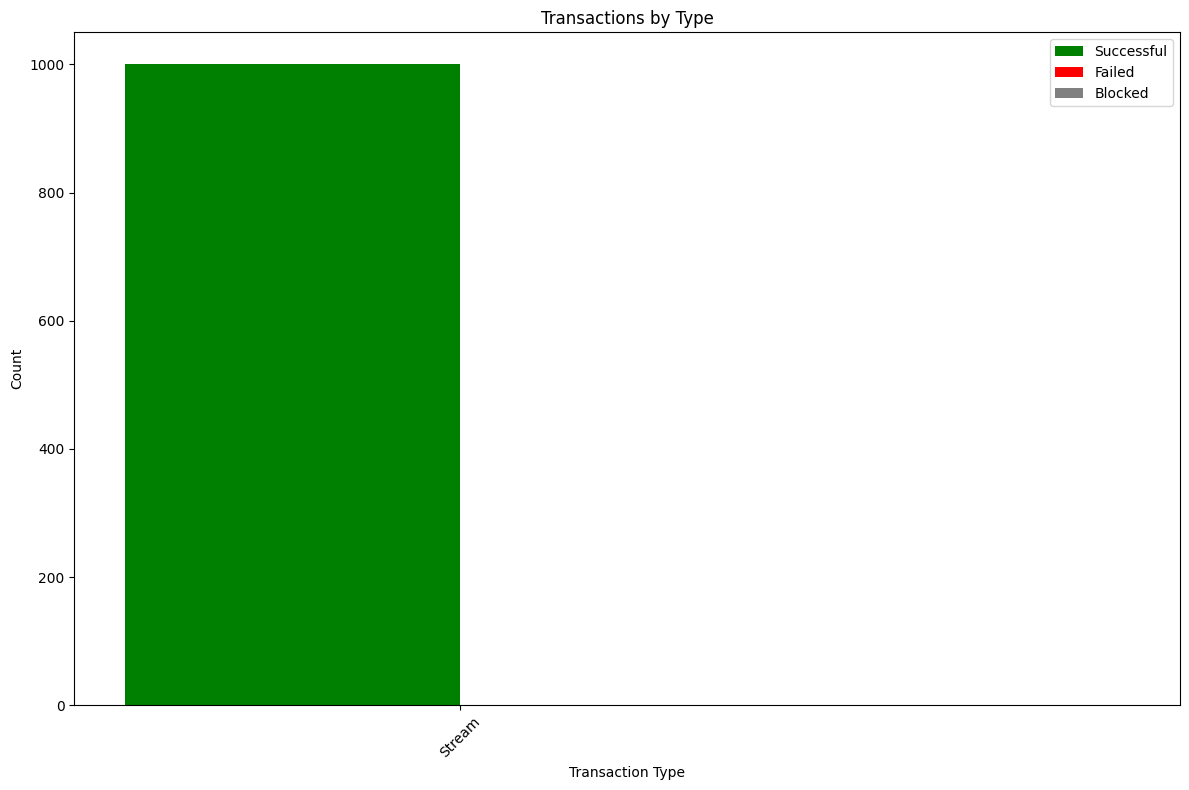


=== Simulating Transactions with Failure Scenario ===

=== Simulation Results ===
Total Transactions: 1000
Successful Transactions: 1000
Failed Transactions: 0

Blocked Transactions: 0

Summary by Transaction Type:
  Stream: 1000 successful, 0 failed, 0 blocked

Summary by Component:
  stream_user_wf: Processed 1000, Failed 0, Blocked 0
  stream_streamer_ms: Processed 1000, Failed 0, Blocked 0
  stream_streamer_db: Processed 1000, Failed 0, Blocked 0

Details of Failed Transactions:


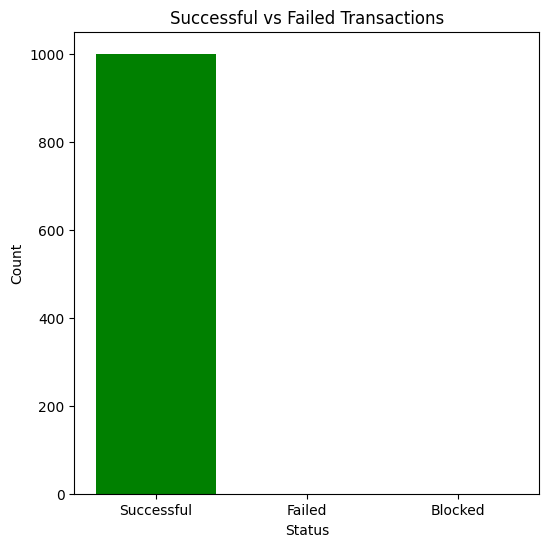

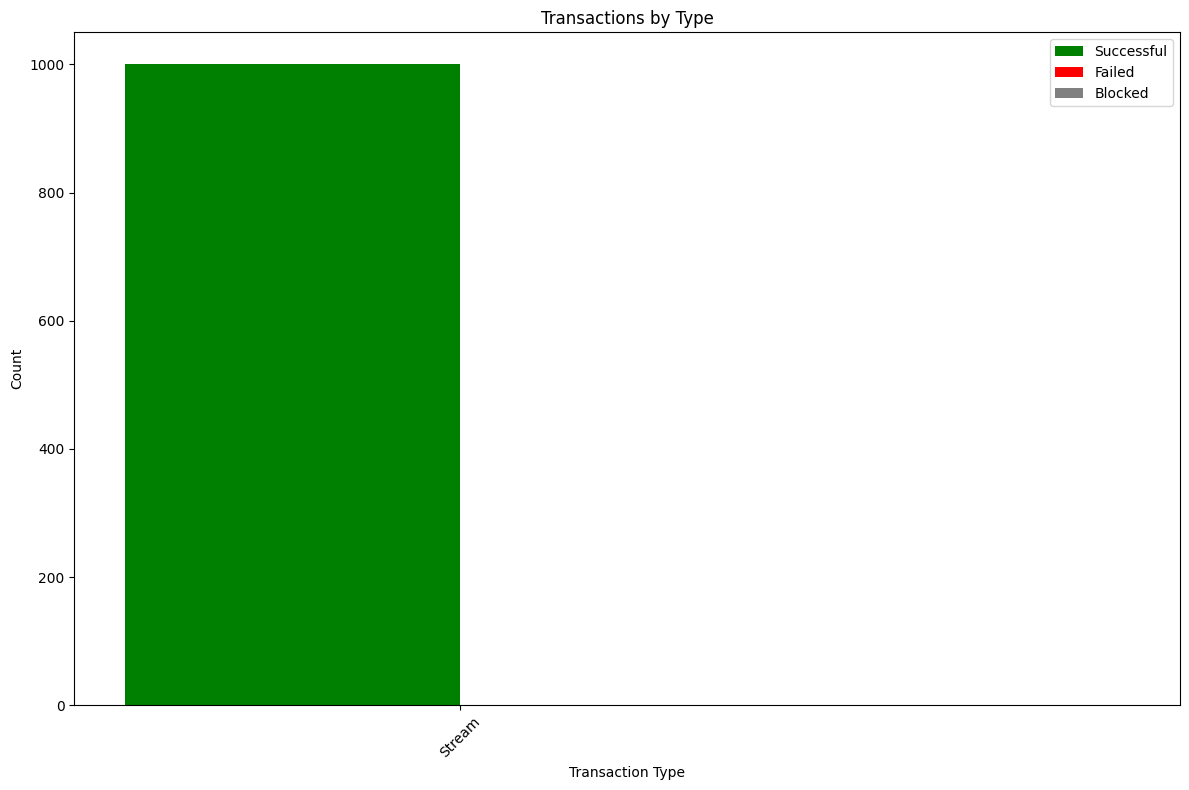


=== Architecture Representation After Failure ===


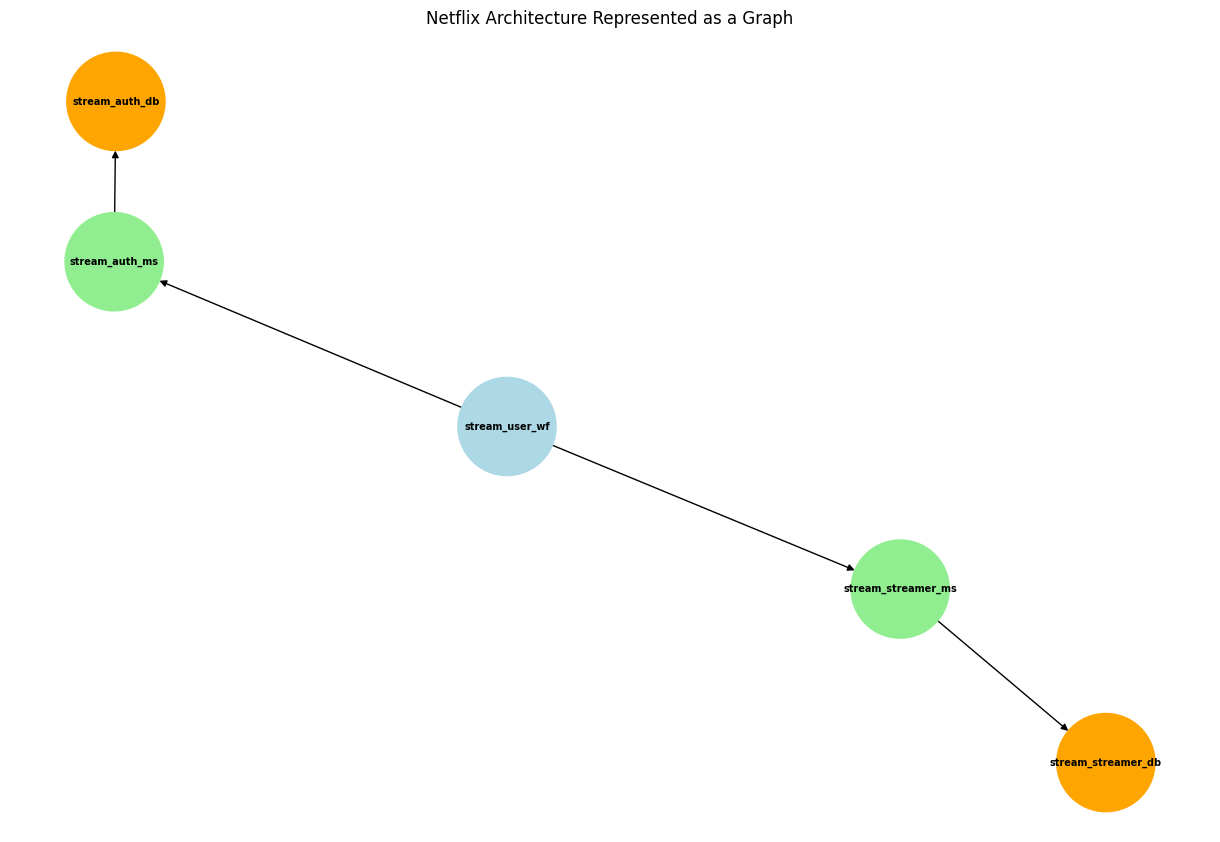

In [ ]:
index = 10
current_weight = 10
max_weight = 10
# Para ejecutar la función, simplemente llámala:
run_stream_simulation()


## **Iteration 2**

This iteration consists of adding the following components to the architecture:

1. API Gateway

2. Firewall

- Architectural (Diagram)
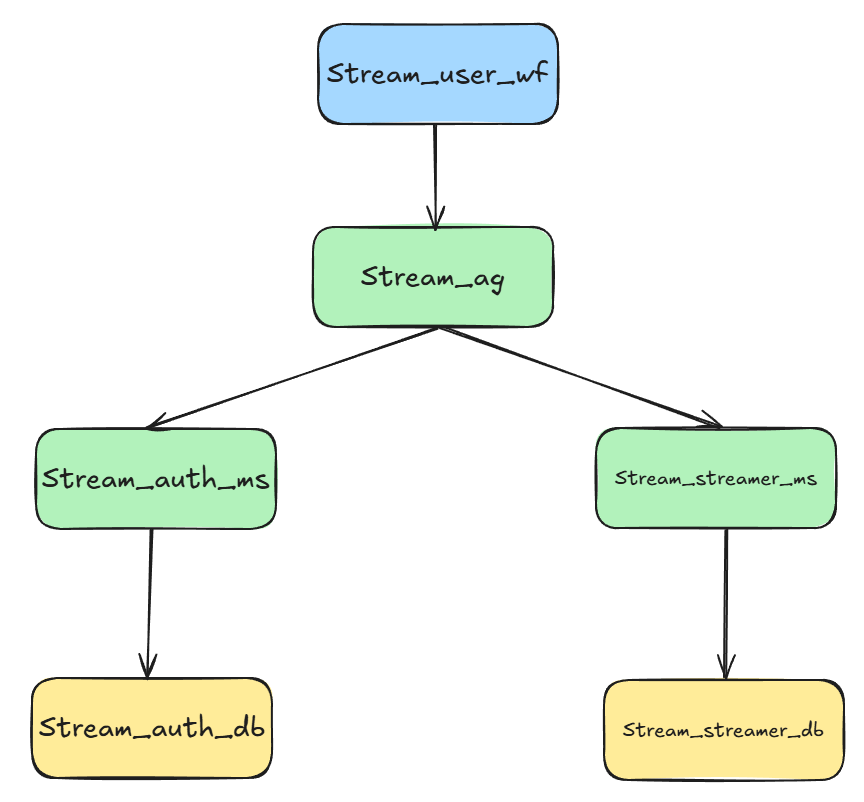



---



### Modelado

In [ ]:
import threading
import time
import random
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

# ================================
# 1. Modeling
# ================================

class Component:
    """
    Base class for all architecture components.
    """
    def __init__(self, name, component_type, capacity=100):
        self.name = name
        self.component_type = component_type
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process_transaction(self, transaction):
        """
        Processes a transaction. Returns True if the transaction is processed successfully,
        or False if the component's capacity is exceeded.
        """

        global ips

        if transaction.request_ip not in ips:
          return 'Blocked'

        with self.lock:
            if self.current_load >= self.capacity:
                return 'Failed'  # Over capacity failure
            self.current_load += 1
        # Simulate processing time
        processing_time = random.uniform(0.01, 0.05)
        time.sleep(processing_time)
        with self.lock:
            self.current_load -= 1
        return 'Success'

class PresentationTier(Component):
    """
    Class for components in Presentation Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Presentation Tier", capacity)

class LogicTier(Component):
    """
    Class for components in Logic Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Logic Tier", capacity)

class DataTier(Component):
    """
    Class for components in Data Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Data Tier", capacity)

class CyberPhysicalTier(Component):
    """
    Class for components in CyberPhysical Tier
    """
    def __init__(self, name, capacity=1000):
        super().__init__(name, "CyberPhysical Tier", capacity)

class TransactionType(Enum):
    AUTH = 1
    STREAM = 2

class Transaction:
    """
    Represents a transaction in the system.
    """
    def __init__(self, user, request_ip, transaction_type):
        self.user = user  # User identifier (e.g., "user_ma_1")
        self.request_ip = request_ip
        self.transaction_type = transaction_type
        self.components_involved = []
        self.status = None  # "Success", "Failed" or "Blocked"

In [ ]:
def setup_architecture():
    """
    Sets up the system architecture by instantiating components and defining their connections.
    """
    components = {}
    graph = nx.DiGraph()

    # Presentation Tier
    components['stream_user_wf'] = PresentationTier('ertms_user_ma', capacity=200)

    # Logic Tier
    components['stream_ag'] = LogicTier('stream_ag', capacity=500)
    components['stream_auth_ms'] = LogicTier('stream_auth_ms', capacity=300)
    components['stream_streamer_ms'] = LogicTier('stream_streamer_ms', capacity=300)


    # Data Tier
    components['stream_auth_db'] = DataTier('stream_auth_db', capacity=300)
    components['stream_streamer_db'] = DataTier('stream_streamer_db', capacity=300)

    # Define connections between components
    graph.add_edge('stream_user_wf', 'stream_ag')

    graph.add_edge('stream_ag', 'stream_auth_ms')
    graph.add_edge('stream_ag', 'stream_streamer_ms')

    graph.add_edge('stream_auth_ms', 'stream_auth_db')

    graph.add_edge('stream_streamer_ms', 'stream_streamer_db')

    return components, graph

def simulate_transaction(transaction, components, metrics):
    """
    Simulates the processing of a transaction through the involved components.
    """
    if transaction.transaction_type == TransactionType.AUTH:
        components_sequence = ['stream_user_wf', 'stream_ag', 'stream_auth_ms', 'stream_auth_db']
    elif transaction.transaction_type == TransactionType.STREAM:
        components_sequence = ['stream_user_wf', 'stream_ag', 'stream_streamer_ms', 'stream_streamer_db']
    else:
        components_sequence = []

    transaction.components_involved = components_sequence
    success = True
    for comp_name in components_sequence:
        component = components.get(comp_name)
        if component:
            transaction.status = component.process_transaction(transaction)
            break
        else:
            success = False
            transaction.status = 'Failed'
            break
    metrics.append(transaction)


### Ejecutar simulación

=== Initial Architecture Representation ===


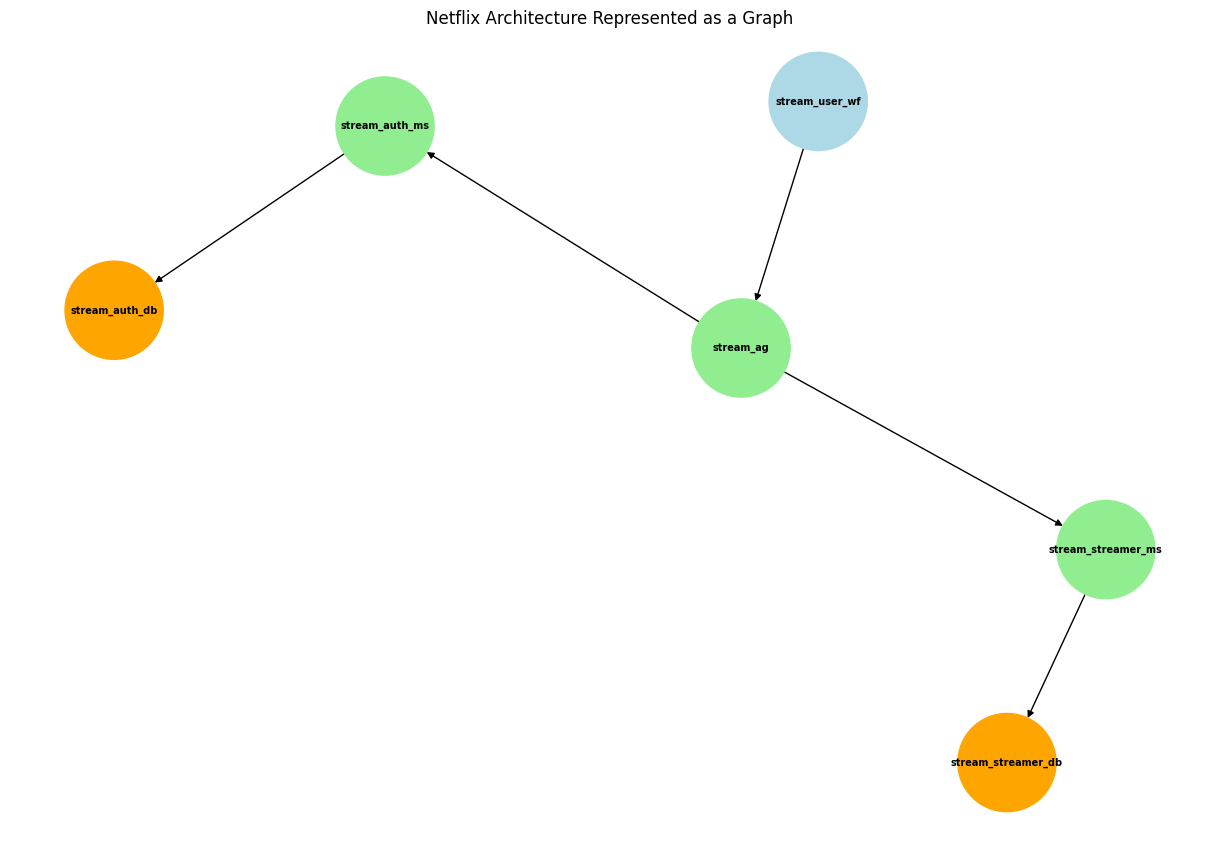


=== Simulating Transactions with Initial Architecture ===

=== Simulation Results ===
Total Transactions: 1000
Successful Transactions: 1000
Failed Transactions: 0

Blocked Transactions: 0

Summary by Transaction Type:
  Stream: 1000 successful, 0 failed, 0 blocked

Summary by Component:
  stream_user_wf: Processed 1000, Failed 0, Blocked 0
  stream_ag: Processed 1000, Failed 0, Blocked 0
  stream_streamer_ms: Processed 1000, Failed 0, Blocked 0
  stream_streamer_db: Processed 1000, Failed 0, Blocked 0

Details of Failed Transactions:


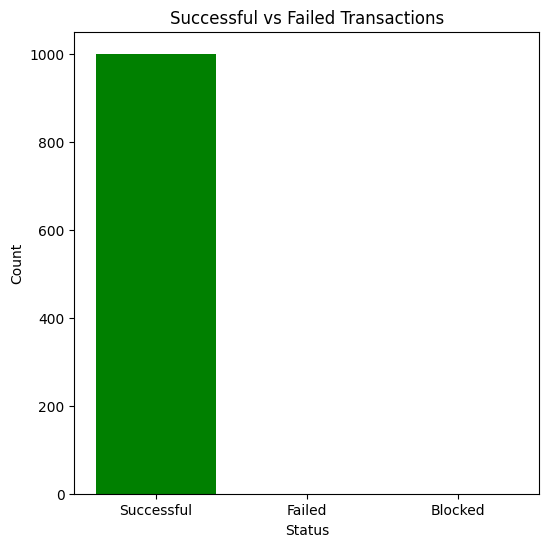

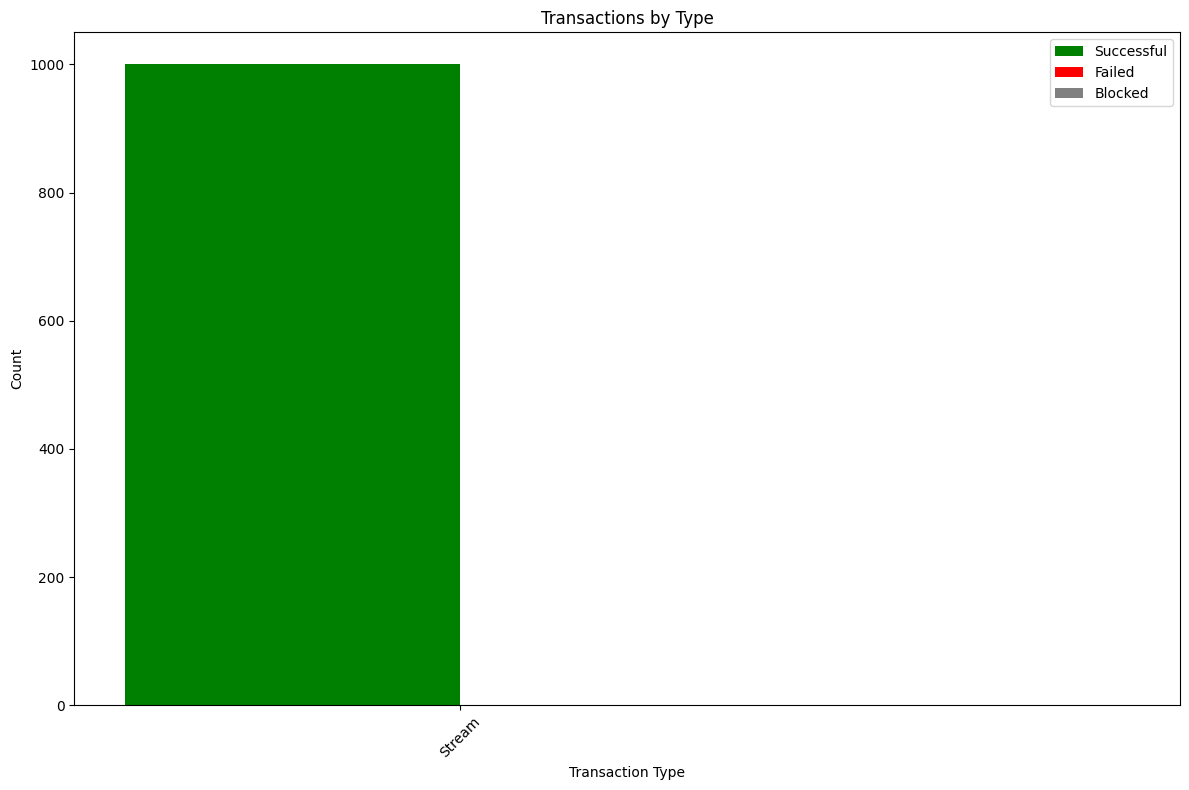


=== Simulating Transactions with Failure Scenario ===

=== Simulation Results ===
Total Transactions: 1000
Successful Transactions: 0
Failed Transactions: 0

Blocked Transactions: 1000

Summary by Transaction Type:
  Stream: 0 successful, 0 failed, 1000 blocked

Summary by Component:
  stream_user_wf: Processed 1000, Failed 0, Blocked 1000
  stream_ag: Processed 1000, Failed 0, Blocked 1000
  stream_streamer_ms: Processed 1000, Failed 0, Blocked 1000
  stream_streamer_db: Processed 1000, Failed 0, Blocked 1000

Details of Failed Transactions:


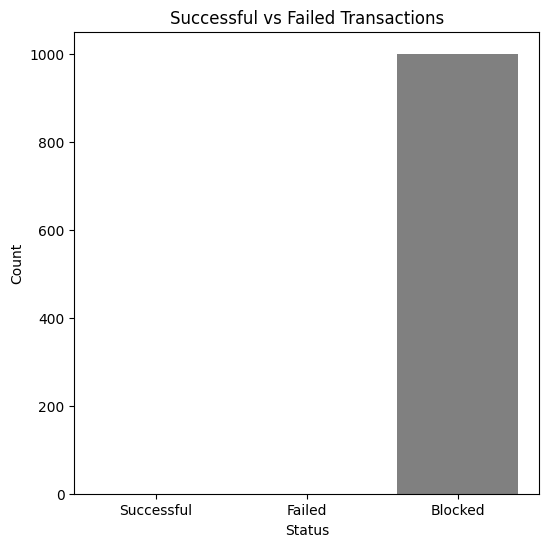

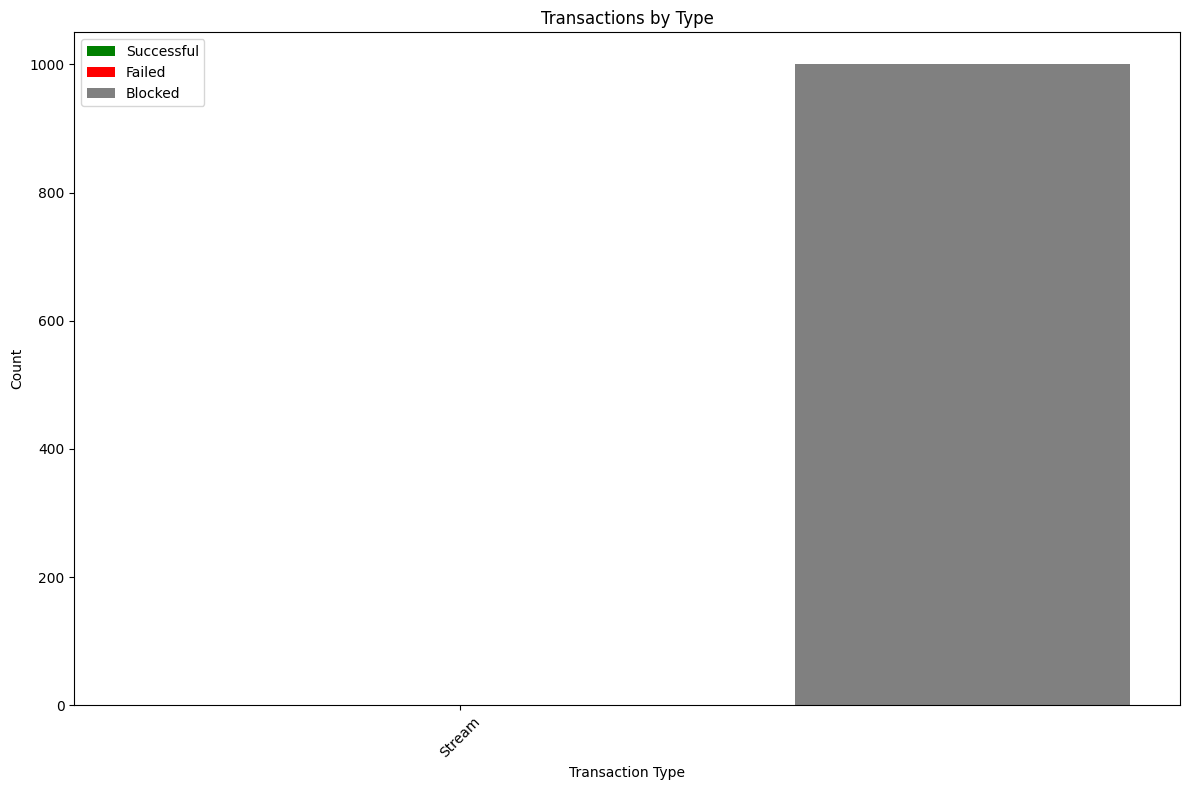


=== Architecture Representation After Failure ===


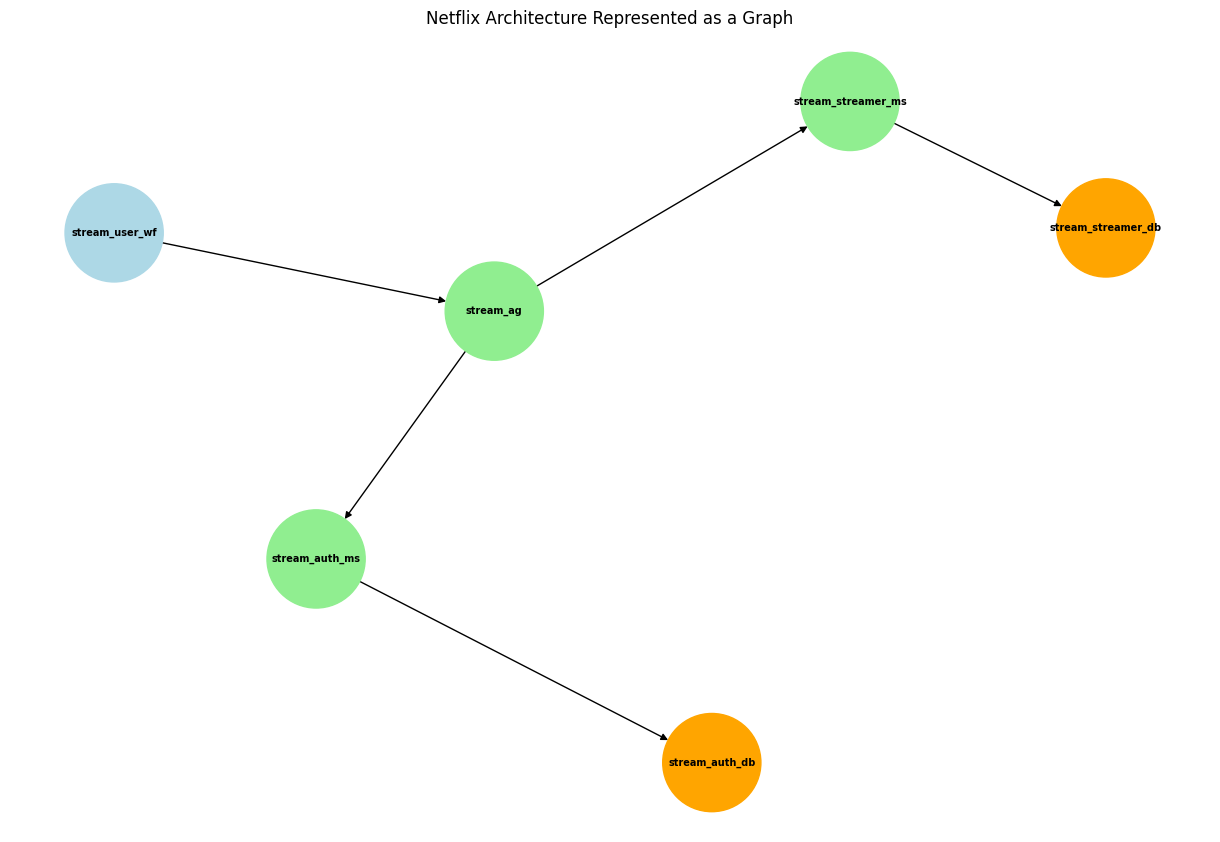

In [ ]:
index = 10
current_weight = 10
max_weight = 10
# Para ejecutar la función, simplemente llámala:
run_stream_simulation()

## Iteration 3

In this iteration, we added cache memory to our infrastructure.
In this simulation, the cache is not used; only the database is queried to simulate how transactions take longer to be processed. This simulation will take some time to execute.

1. Enable Cache:

   - This function adds the "stream_cache" component to the architecture. Its purpose is to improve performance and reduce the load on the stream_streamer_ms microservice by preventing popular content from being repeatedly requested from the streaming service.

   - How does it work?

     When a transaction of type STREAM requests content, the system first checks whether that content is already stored in stream_cache.

     If the content is in the cache, the transaction is immediately marked as successful. The step involving the stream_streamer_ms service is skipped. This is considered a "cache hit".

     If the content is not in the cache, the transaction is forwarded to the stream_streamer_ms service. If the streamer responds successfully, the content is stored in the cache for future requests. This is considered a "cache miss".

     The cache has a limited maximum capacity. When this limit is reached, the oldest content is removed using a FIFO policy.

   - The graph displays the total number of requests, the ones that accessed the cache, and those that were served by the stream_streamer_ms service.

- Architectural (Diagram)

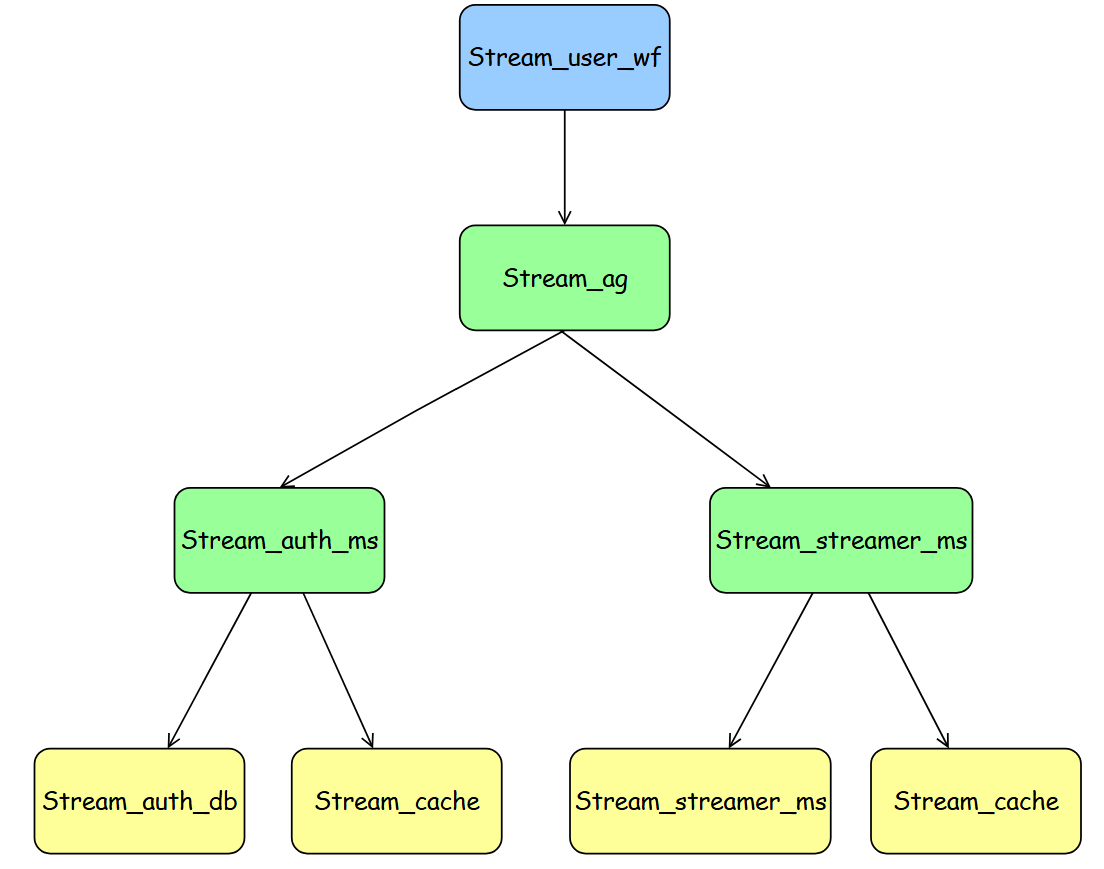

### Iteration Simulation

In [ ]:
def run_stream_simulation():
    """
    Configura la arquitectura del sistema, ejecuta la simulación de transacciones,
    reporta los resultados, visualiza las métricas y representa la arquitectura antes y después
    de inducir una falla.
    """
    # Setup architecture
    components, graph = setup_architecture()

    # Metrics collection
    metrics = []

    # Simulate transactions with initial capacity
    #print("\n=== Simulating Transactions with Initial Architecture ===")
    run_simulation(components, metrics)
    #report_metrics(metrics)
    #visualize_metrics(metrics)

    # Clear previous metrics
    metrics.clear()

    # Simulate transactions to streamer service without cache
    print("\n=== Simulating Transactions with Failure Scenario ===")
    run_simulation(components, metrics, True)
    visualize_cache_usage(metrics)

    # Represent the architecture
    print("\n=== Architecture Representation After Failure ===")
    represent_graph(graph, components)

### Modelado

In [ ]:
import threading
import time
import random
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

# ================================
# 1. Modeling
# ================================

class Component:
    """
    Base class for all architecture components.
    """
    def __init__(self, name, component_type, capacity=100):
        self.name = name
        self.component_type = component_type
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process_transaction(self, transaction):
        """
        Processes a transaction. Returns True if the transaction is processed successfully,
        or False if the component's capacity is exceeded.
        """

        with self.lock:
            if self.current_load >= self.capacity:
                return 'Failed'  # Over capacity failure
            self.current_load += 1
        # Simulate processing time
        processing_time = random.uniform(0.01, 0.05)
        time.sleep(processing_time)
        with self.lock:
            self.current_load -= 1
        return 'Success'

class PresentationTier(Component):
    """
    Class for components in Presentation Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Presentation Tier", capacity)

class LogicTier(Component):
    """
    Class for components in Logic Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Logic Tier", capacity)

class DataTier(Component):
    """
    Class for components in Data Tier
    """
    def __init__(self, name, capacity=100):
        time.sleep(0.1)
        super().__init__(name, "Data Tier", capacity)

class CyberPhysicalTier(Component):
    """
    Class for components in CyberPhysical Tier
    """
    def __init__(self, name, capacity=1000):
        super().__init__(name, "CyberPhysical Tier", capacity)

class TransactionType(Enum):
    AUTH = 1
    STREAM = 2

class Transaction:
    """
    Represents a transaction in the system.
    """
    def __init__(self, user, request_ip, transaction_type):
        self.user = user  # User identifier (e.g., "user_ma_1")
        self.request_ip = request_ip
        self.transaction_type = transaction_type
        self.components_involved = []
        self.status = None  # "Success", "Failed" or "Blocked"

class CacheTier(DataTier):
    def __init__(self, name, capacity=300):
        super().__init__(name, capacity)
        self.cache_store = []

    def check_cache(self, content_id):
        return content_id in self.cache_store

    def cache_content(self, content_id):
        if content_id not in self.cache_store:
            if len(self.cache_store) >= self.capacity:
                self.cache_store.pop(0)
            self.cache_store.append(content_id)

In [ ]:
def setup_architecture():
  """
  Sets up the system architecture by instantiating components and defining their connections.
  """
  components = {}
  graph = nx.DiGraph()

  # Presentation Tier
  components['stream_user_wf'] = PresentationTier('ertms_user_ma', capacity=200)

  # Logic Tier
  components['stream_ag'] = LogicTier('stream_ag', capacity=500)
  components['stream_auth_ms'] = LogicTier('stream_auth_ms', capacity=300)
  components['stream_streamer_ms'] = LogicTier('stream_streamer_ms', capacity=300)

  # Data Tier
  components['stream_auth_db'] = DataTier('stream_auth_db', capacity=300)
  components['stream_streamer_db'] = DataTier('stream_streamer_db', capacity=300)
  components['stream_cache'] = CacheTier('stream_cache', capacity=300)
  graph.add_edge('stream_streamer_ms', 'stream_cache')

  # Define connections between components
  graph.add_edge('stream_user_wf', 'stream_ag')

  graph.add_edge('stream_ag', 'stream_auth_ms')
  graph.add_edge('stream_ag', 'stream_streamer_ms')

  graph.add_edge('stream_auth_ms', 'stream_auth_db')

  graph.add_edge('stream_streamer_ms', 'stream_streamer_db')

  return components, graph

### Simulación

In [ ]:
def run_simulation(components, metrics, inject_failure=False, total_stream_requests=1000):
    """
    Runs the simulation of concurrent transactions.
    """
    threads = []

    # Listado del contenido disponible
    media_library = {
        f"movie_{i:03d}": f"Movie Title {i}" for i in range(1, 101)
    }

    # Tokens válidos
    valid_tokens = {
        "token123",
        "token456",
        "token789"
    }

    # IPs validas
    global ips
    ips = ["192.168.3.15", "10.0.105.22", "172.25.1.88"]

    possible_tokens = list(valid_tokens) + ["invalid_token"]
    possible_contents = list(media_library.keys()) + ["movie_999"]  # Contenido no existente
    possible_ips = ips

    if inject_failure:
      possible_ips = ["203.0.113.45"]

    start_time = time.time()
    print("Simulation in progress\n")
    for i in range(1, total_stream_requests + 1):
      user_token = random.choice(possible_tokens)
      content_id = random.choice(possible_contents)
      ip = random.choice(possible_ips)

      transaction = Transaction(user_token, ip, TransactionType.STREAM)

      # Proceed to db
      transaction.components_involved = ['stream_user_ms', 'stream_cache', 'stream_streamer_db']
      result = components['stream_streamer_db'].process_transaction(transaction)
      if result == 'Success':
          components['stream_cache'].cache_content(content_id)
          transaction.status = 'Success'
      else:
          transaction.status = 'Failed'
      metrics.append(transaction)

      thread = threading.Thread(target=simulate_transaction, args=(transaction, components, metrics))
      threads.append(thread)
      thread.start()

    for thread in threads:
        thread.join()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTiempo total de simulación: {total_time:.3f} segundos")

### Ejecutar Simulación

Simulation in progress


Tiempo total de simulación: 30.665 segundos

=== Simulating Transactions with Failure Scenario ===
Simulation in progress


Tiempo total de simulación: 30.294 segundos

=== Métricas de Caché ===

Total de accesos a la caché: 2000
Total de hits desde la caché: 0
Total de hits desde la base de datos: 2000



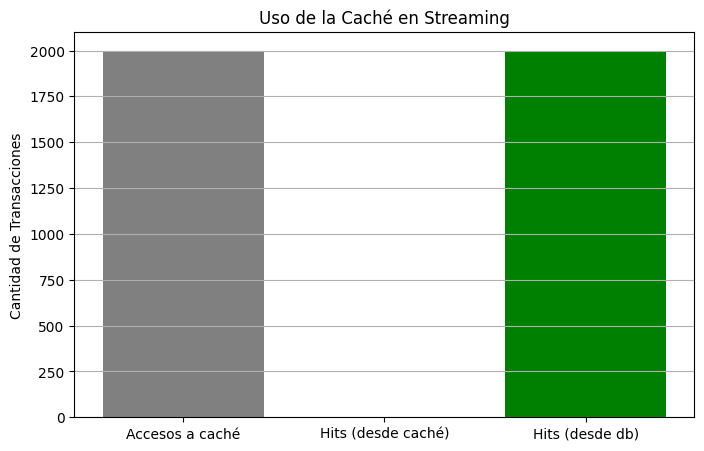


=== Architecture Representation After Failure ===


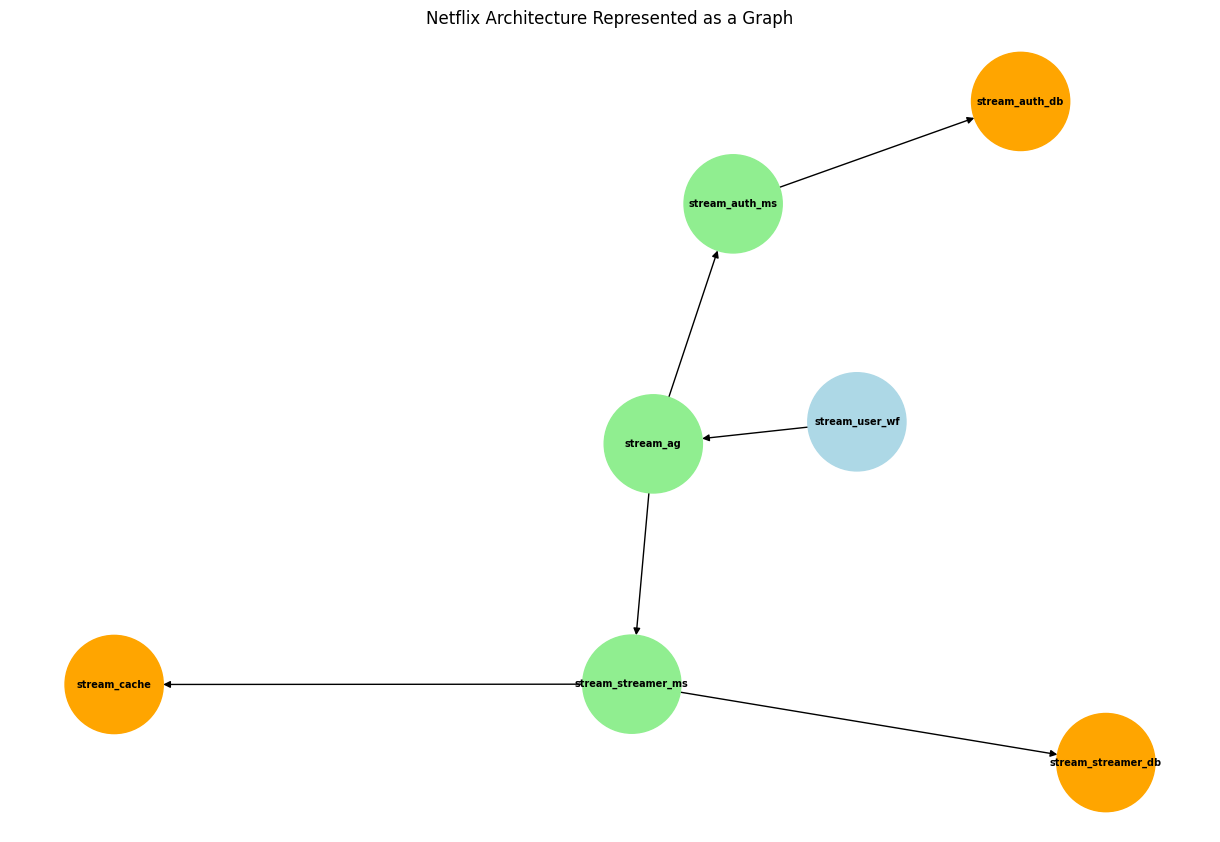

In [ ]:
index = 10
current_weight = 10
max_weight = 10
# Para ejecutar la función, simplemente llámala:
run_stream_simulation()

## **Iteration 4**


This iteration consists of adding the following features to the architecture:

1. Load Balancer:

The Stream_lb component serves as the load balancer in this architecture. It was implemented to distribute incoming requests from the Stream_user_wf component to the agents (Stream_ag_1 and Stream_ag_2), which act as gateways to the microservices.

- Functionality and Purpose:
  - Load Distribution: Stream_lb ensures that no single agent or microservice becomes overloaded by evenly distributing incoming traffic.

  - High Availability: In the event of a failure in one of the agents, the load balancer can redirect traffic to the other, maintaining service continuity.

  - Scalability: New agents (Stream_ag_N) can be added without requiring changes to the entry point of the system.

- Load Balancing Strategy:
  - A Round Robin policy is used, which sequentially assigns each incoming request to the next available agent in a circular list.

- Architectural (Diagram)
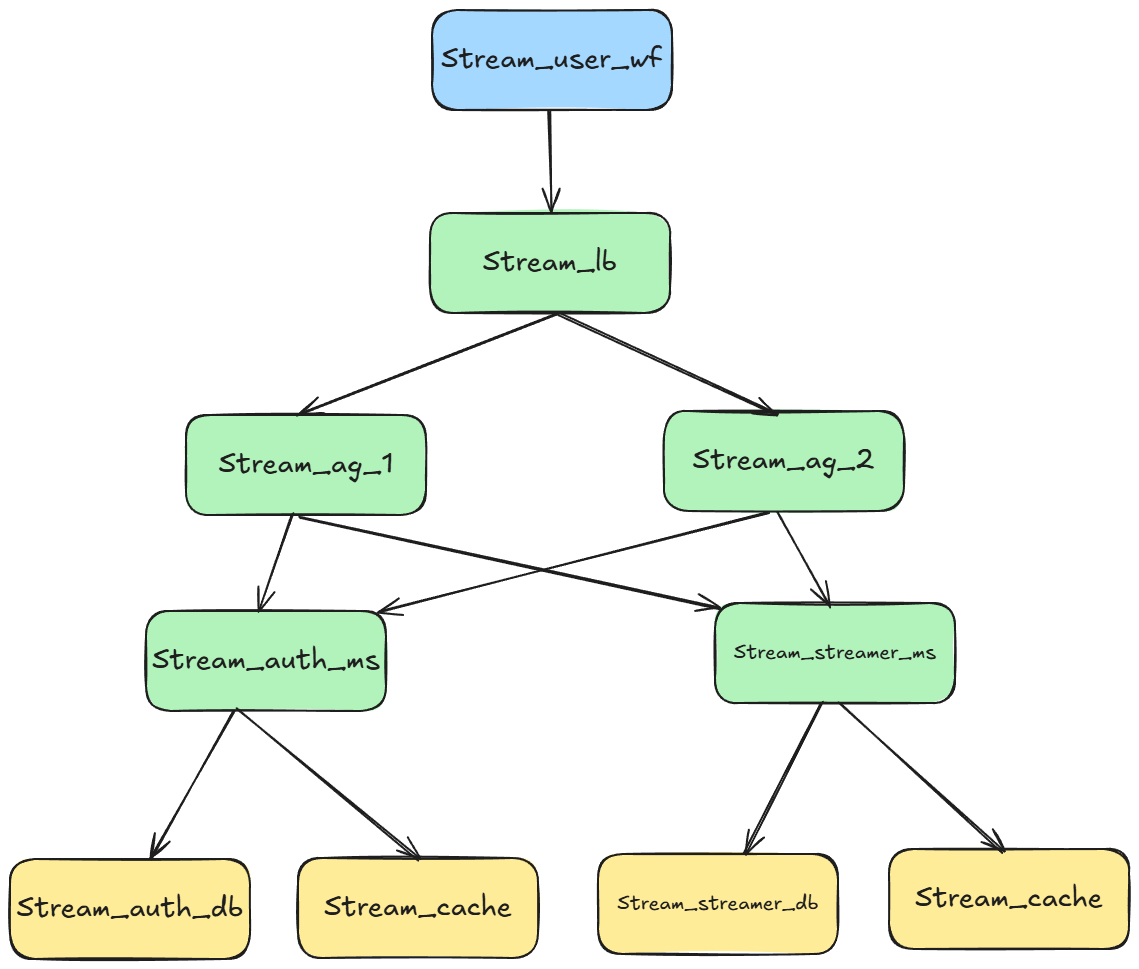


### Iteration simulation

In [ ]:
def run_stream_simulation():
    """
    Configura la arquitectura del sistema, ejecuta la simulación de transacciones,
    reporta los resultados, visualiza las métricas y representa la arquitectura antes y después
    de inducir una falla.
    """
    # Setup architecture
    components, graph = setup_architecture()

    # Metrics collection
    metrics = []

    # Clear previous metrics
    metrics.clear()

    # Simulate transactions after inducing failure
    print("\n=== Simulating Transactions with Failure Scenario ===")
    run_simulation(components, metrics, True)
    visualize_cache_usage(metrics)

    # Represent the architecture after failure
    print("\n=== Architecture Representation After Failure ===")
    represent_graph(graph, components)

### Modelado

In [ ]:
import threading
import time
import random
import hashlib
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from enum import Enum

# ================================
# 1. Modeling
# ================================

class Component:
    """
    Base class for all architecture components.
    """
    def __init__(self, name, component_type, capacity=100):
        self.name = name
        self.component_type = component_type
        self.capacity = capacity
        self.lock = threading.Lock()
        self.current_load = 0

    def process_transaction(self, transaction):
        """
        Processes a transaction. Returns True if the transaction is processed successfully,
        or False if the component's capacity is exceeded.
        """

        with self.lock:
            if self.current_load >= self.capacity:
                return 'Failed'  # Over capacity failure
            self.current_load += 1
        # Simulate processing time
        processing_time = random.uniform(0.01, 0.05)
        time.sleep(processing_time)
        with self.lock:
            self.current_load -= 1
        return 'Success'

class PresentationTier(Component):
    """
    Class for components in Presentation Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Presentation Tier", capacity)

class LogicTier(Component):
    """
    Class for components in Logic Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Logic Tier", capacity)

class DataTier(Component):
    """
    Class for components in Data Tier
    """
    def __init__(self, name, capacity=100):
        super().__init__(name, "Data Tier", capacity)

class CyberPhysicalTier(Component):
    """
    Class for components in CyberPhysical Tier
    """
    def __init__(self, name, capacity=1000):
        super().__init__(name, "CyberPhysical Tier", capacity)

class TransactionType(Enum):
    AUTH = 1
    STREAM = 2

class Transaction:
    """
    Represents a transaction in the system.
    """
    def __init__(self, user, request_ip, transaction_type):
        self.user = user  # User identifier (e.g., "user_ma_1")
        self.request_ip = request_ip
        self.transaction_type = transaction_type
        self.components_involved = []
        self.status = None  # "Success", "Failed" or "Blocked"

In [ ]:
def setup_architecture():
  """
  Sets up the system architecture by instantiating components and defining their connections.
  """
  components = {}
  graph = nx.DiGraph()

  # Presentation Tier
  components['stream_user_wf'] = PresentationTier('ertms_user_ma', capacity=200)

  # Logic Tier
  components['stream_lb'] = LogicTier('stream_lb', capacity=1500)
  components['stream_ag_1'] = LogicTier('stream_ag', capacity=500)
  components['stream_ag_2'] = LogicTier('stream_ag', capacity=900)
  components['stream_auth_ms'] = LogicTier('stream_auth_ms', capacity=300)
  components['stream_streamer_ms'] = LogicTier('stream_streamer_ms', capacity=300)

  # Data Tier
  components['stream_auth_db'] = DataTier('stream_auth_db', capacity=300)
  components['stream_streamer_db'] = DataTier('stream_streamer_db', capacity=300)
  components['stream_cache'] = CacheTier('stream_cache', capacity=300)
  graph.add_edge('stream_streamer_ms', 'stream_cache')

  # Define connections between components
  graph.add_edge('stream_user_wf', 'stream_lb')

  graph.add_edge('stream_lb', 'stream_ag_1')
  graph.add_edge('stream_lb', 'stream_ag_2')

  graph.add_edge('stream_ag_1', 'stream_auth_ms')
  graph.add_edge('stream_ag_1', 'stream_streamer_ms')

  graph.add_edge('stream_ag_2', 'stream_auth_ms')
  graph.add_edge('stream_ag_2', 'stream_streamer_ms')

  graph.add_edge('stream_auth_ms', 'stream_auth_db')

  graph.add_edge('stream_streamer_ms', 'stream_streamer_db')

  return components, graph

def simulate_transaction(transaction, components, metrics):
  """
  Simulates the processing of a transaction through the involved components.
  """

  # Round Robin index for Load Balancer
  # Initialize it outside the function to maintain state across calls
  if 'lb_index' not in simulate_transaction.__dict__:
    simulate_transaction.lb_index = 0

  if transaction.transaction_type == TransactionType.AUTH:
      # Use Load Balancer to choose between stream_ag_1 and stream_ag_2
      ag_component_name = ['stream_ag_1', 'stream_ag_2'][simulate_transaction.lb_index % 2]
      components_sequence = ['stream_user_wf', 'stream_lb', ag_component_name, 'stream_auth_ms', 'stream_auth_db']
  elif transaction.transaction_type == TransactionType.STREAM:
      # For STREAM, always use stream_ag_2 (you can modify if needed)
      components_sequence = ['stream_user_wf', 'stream_lb', 'stream_ag_2', 'stream_streamer_ms', 'stream_streamer_db']
  else:
      components_sequence = []

  transaction.components_involved = components_sequence
  success = True
  for comp_name in components_sequence:
      component = components.get(comp_name)
      if component:
          transaction.status = component.process_transaction(transaction)
          if transaction.status != 'Success':
              success = False
              break
      else:
          success = False
          transaction.status = 'Failed'
          break
  metrics.append(transaction)

  # Increment the Load Balancer index for the next transaction
  simulate_transaction.lb_index += 1


### Simulación

In [ ]:
def run_simulation(components, metrics, inject_failure=False, total_stream_requests=1000):
    """
    Runs the simulation of concurrent transactions.
    """
    threads = []

    # Listado del contenido disponible
    media_library = {
        f"movie_{i:03d}": f"Movie Title {i}" for i in range(1, 101)
    }

    # Tokens válidos
    valid_tokens = {
        "token123",
        "token456",
        "token789"
    }

    # IPs validas
    global ips
    ips = ["192.168.3.15", "10.0.105.22", "172.25.1.88"]

    possible_tokens = list(valid_tokens) + ["invalid_token"]
    possible_contents = list(media_library.keys()) + ["movie_999"]  # Contenido no existente
    possible_ips = ips

    if inject_failure:
      possible_ips = ["203.0.113.45"]

    # Contadores de uso de caché
    global cache_access_count
    cache_access_count = 0

    start_time = time.time()
    for i in range(1, total_stream_requests + 1):
      user_token = random.choice(possible_tokens)
      content_id = random.choice(possible_contents)
      ip = random.choice(possible_ips)

      transaction = Transaction(user_token, ip, TransactionType.STREAM)

      # Check cache first
      cache_access_count += 1
      if components['stream_cache'].check_cache(content_id):
          transaction.status = 'Success'
          transaction.components_involved = ['stream_user_ms', 'stream_cache']
          metrics.append(transaction)
          continue
      else:
          # Proceed to db
          transaction.components_involved = ['stream_user_ms', 'stream_cache', 'stream_streamer_db']
          result = components['stream_streamer_db'].process_transaction(transaction)
          if result == 'Success':
              components['stream_cache'].cache_content(content_id)
              transaction.status = 'Success'
          else:
              transaction.status = 'Failed'
          metrics.append(transaction)
          continue
      thread = threading.Thread(target=simulate_transaction, args=(transaction, components, metrics))
      threads.append(thread)
      thread.start()

    for thread in threads:
        thread.join()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTiempo total de simulación: {total_time:.3f} segundos")

### Ejecutar simulación


=== Simulating Transactions with Failure Scenario ===

Tiempo total de simulación: 3.039 segundos

=== Métricas de Caché ===

Total de accesos a la caché: 1000
Total de hits desde la caché: 899
Total de hits desde la base de datos: 101



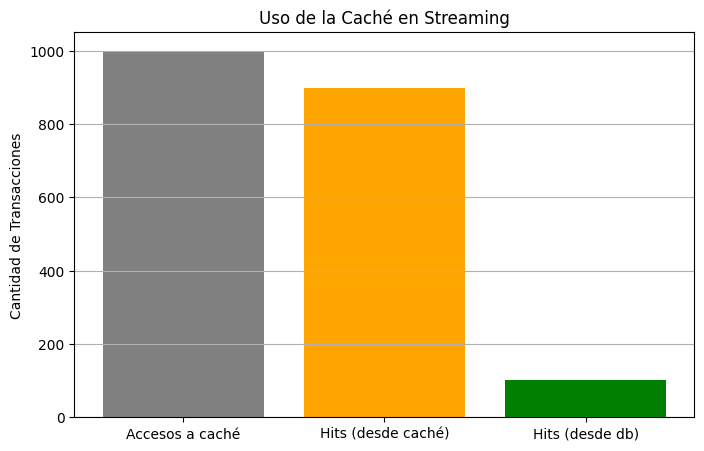


=== Architecture Representation After Failure ===


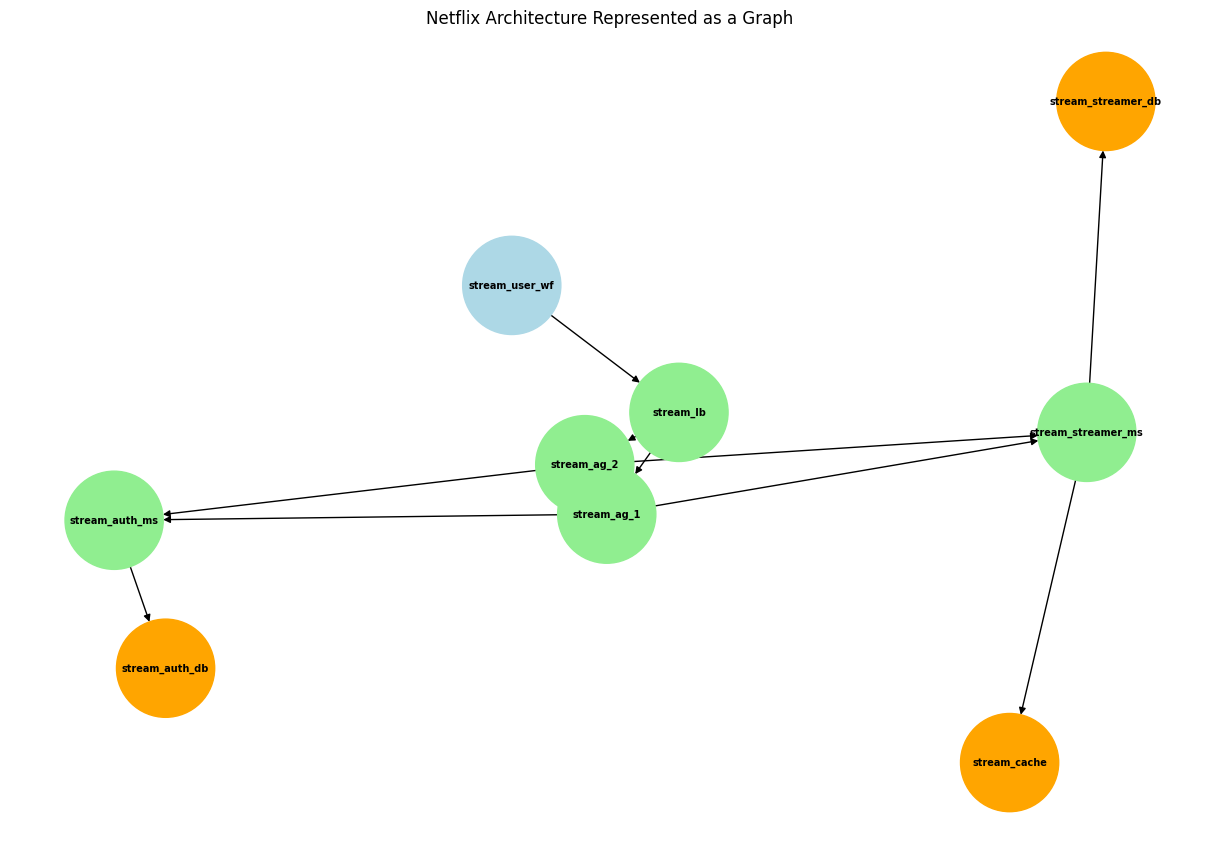

In [ ]:
index = 10
current_weight = 10
max_weight = 10
# Para ejecutar la función, simplemente llámala:
run_stream_simulation()